In [1]:
import math 
import pandas_datareader as web
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt 
import seaborn as sn 
plt.style.use('fivethirtyeight')

In [3]:
df = web.DataReader('AAPL',data_source='yahoo',start='2012-01-01',end='2021-05-01')
df 

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.629209
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.697079
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.838044
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.972249
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.951672
...,...,...,...,...,...,...
2021-04-26,135.059998,133.559998,134.830002,134.720001,66905100.0,134.491562
2021-04-27,135.410004,134.110001,135.009995,134.389999,66015800.0,134.162109
2021-04-28,135.020004,133.080002,134.309998,133.580002,107760100.0,133.353485


In [4]:
df.shape

(2347, 6)

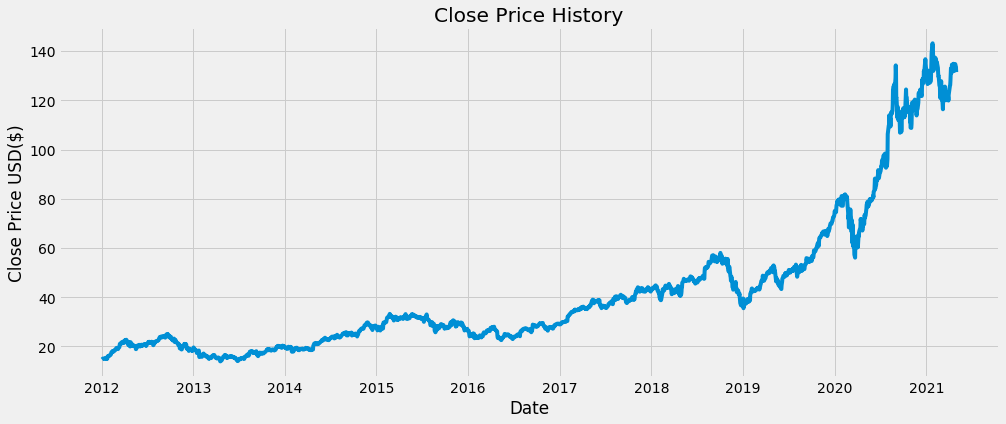

In [5]:
plt.figure(figsize=(15,6))
plt.title("Close Price History")
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel("Close Price USD($)")
plt.show()

In [8]:
close_data = df.filter(['Close'])
dataset = close_data.values
training_data_len = math.ceil(len(dataset) * .8)

In [9]:
#Scale Data 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00572147],
       [0.00633231],
       [0.00760099],
       ...,
       [0.92585855],
       [0.92508459],
       [0.90945151]])

In [18]:
#Create Scaled Training set
train_data_scaled = scaled_data[0:training_data_len , :]

#create x_train, y_train
x_train,y_train = [],[]

for i in range(60, len(train_data_scaled)):
    x_train.append(train_data_scaled[i-60:i, 0])
    y_train.append(train_data_scaled[i, 0])


In [19]:
#Convert to array
x_train,y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1818, 60, 1)

In [21]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [22]:
model.compile(optimizer="adam", loss="mean_squared_error")
model.fit(x_train, y_train, batch_size=1, epochs=20)

Epoch 1/20
1818/1818 [==============================] - 34s 18ms/step - loss: 8.5721e-04
Epoch 2/20
1818/1818 [==============================] - 37s 20ms/step - loss: 1.1221e-04
Epoch 3/20
1818/1818 [==============================] - 40s 22ms/step - loss: 9.7355e-05
Epoch 4/20
1818/1818 [==============================] - 36s 20ms/step - loss: 8.2400e-05
Epoch 5/20
1818/1818 [==============================] - 35s 19ms/step - loss: 5.0695e-05
Epoch 6/20
1818/1818 [==============================] - 35s 19ms/step - loss: 6.5608e-05
Epoch 7/20
1818/1818 [==============================] - 42s 23ms/step - loss: 4.2465e-05
Epoch 8/20
1818/1818 [==============================] - 39s 21ms/step - loss: 3.6380e-05
Epoch 9/20
1818/1818 [==============================] - 39s 22ms/step - loss: 3.9371e-05
Epoch 10/20
1818/1818 [==============================] - 39s 21ms/step - loss: 5.1240e-05
Epoch 11/20
1818/1818 [==============================] - 40s 22ms/step - loss: 4.5977e-05
Epoch 12/20
1818/18

In [23]:
#Create Scaled Train Set
test_data_scaled = scaled_data[training_data_len-60: , :]

#Create x_test dan y_test
x_test, y_test = [], dataset[training_data_len:, :]

for i in range(60,len(test_data_scaled)):
    x_test.append(test_data_scaled[i-60:i, 0])

In [30]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_test.shape

(469, 60, 1)

In [31]:
# Get Predicted Value 
predict = model.predict(x_test)
predict = scaler.inverse_transform(predict)

In [32]:
#Get the root mean squared error (RMSE
rmse = np.sqrt(np.mean(predict - y_test)**2)
rmse

2.2669312450677346

ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<function matplotlib.pyplot.show(*args, **kw)>

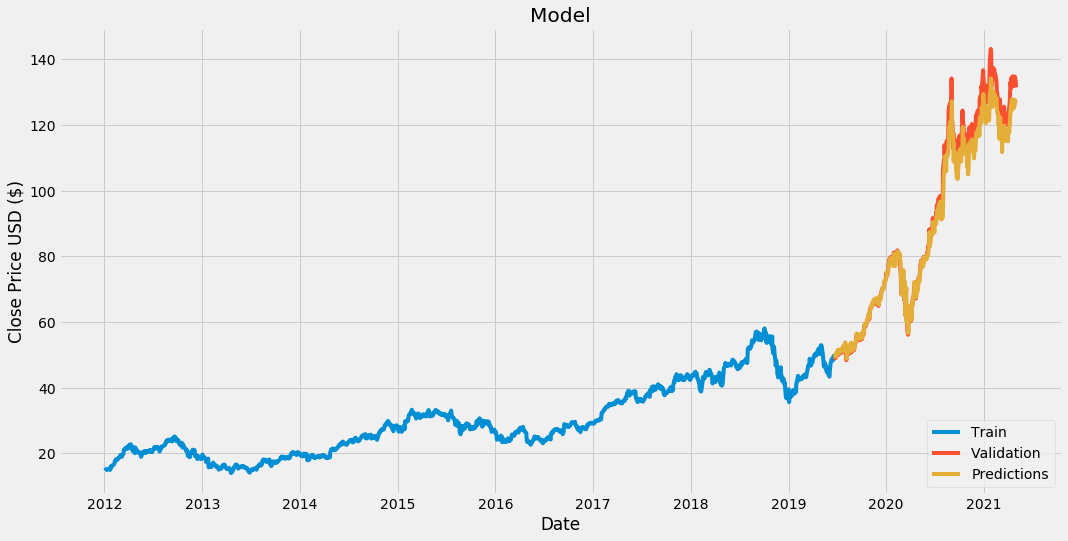

In [33]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predict

#Plot
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train["Close"])
plt.plot(valid[["Close",'Predictions']])
plt.legend(['Train','Validation','Predictions'], loc='lower right')
plt.show 
